In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
# import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *
from proc_revisions.ss_sj_utils import *

In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
cerb_gtf = od+expand(config['lr']['cerberus']['gtf'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]
gtf = od+expand(config['lr']['cerberus']['gtf'], species='human')[0]
alu = od+config['ref']['repeats']['alu_bed']
phastcons = od+config['ref']['phastcons100']['txt']


ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]


ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'

m_ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='mouse')[0]
m_filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='mouse')[0]
m_read_annot = od+expand(config['lr']['talon']['full_annot'], species='mouse')[0]
m_t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='mouse')[0]
m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]
m_swan_file = od+expand(config['lr']['swan']['sg'], species='mouse')[0]
m_cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='mouse', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='mouse')[0]
m_major_isos = od+expand(config['lr']['analysis']['major_isos'], species='mouse', obs_col='sample')[0]
m_pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='mouse', obs_col='sample')[0]
m_pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='mouse')[0]
m_cerb_gtf = od+expand(config['lr']['cerberus']['gtf'], species='mouse')[0]
human_mouse_sect_cons = '../fig5/human_mouse_sect_cons.tsv'


m_ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='mouse')[0]
m_ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='mouse')[0]


orth_table = od+config['ref']['orth_genes']

mouse_ver = 'vM25_cerberus'

In [5]:
def read_cons_table():
    df = pd.read_csv(human_mouse_sect_cons, sep='\t')
    print(len(df.index))
    df['sector_conserved'] = df.sector_human == df.sector_mouse
    df['splicing_conserved']  = (df.sector_human=='splicing')&(df.sector_mouse=='splicing')
    gids = df.loc[(df.sector_human=='splicing')&(df.sector_mouse!='splicing')]['Gene stable ID'].tolist()
    
    # df['cons_cat'] = np.nan

#     # tss
#     df.loc[(df.sector_human=='tss')&\
#            (df.sector_mouse=='tss'), 'cons_cat'] = 'TSS_cons'
#     df.loc[(df.sector_human=='tss')&\
#        (df.sector_mouse!='tss'), 'cons_cat'] = 'TSS_not_cons'
    
#     # splicing
#     df.loc[(df.sector_human=='splicing')&\
#            (df.sector_mouse=='splicing'), 'cons_cat'] = 'Splicing_cons'
#     df.loc[(df.sector_human=='splicing')&\
#        (df.sector_mouse!='splicing'), 'cons_cat'] = 'TSS_not_cons
    return df

def test_print_stat(df, test_col, test='mannwhitneyu'):
    # means of each dist and mann whitney u for each pair
    for s in df.sector_human.unique().tolist():
        print()
        for c in df.sector_conserved.unique().tolist():
            temp = df.loc[(df.sector_human==s)&\
                          (df.sector_conserved==c)].copy(deep=True)
            print(f"Mean of human {s} {c} sector conserved genes: {temp[test_col].mean()}")


    for s in df.sector_human.unique().tolist():
        print()
        for c in df.sector_conserved.unique().tolist():
            temp = df.loc[(df.sector_human==s)&\
                          (df.sector_conserved==c)].copy(deep=True)
            print(f"Median of human {s} {c} sector conserved genes: {temp[test_col].median()}")

    print()
    for s in df.sector_human.unique().tolist():  
        temp = df.loc[df.sector_human==s].copy(deep=True)
        a = temp.loc[temp.sector_conserved==True][test_col].tolist()
        b = temp.loc[temp.sector_conserved==False][test_col].tolist()
        if test=='mannwhitneyu':
            stat, pval = st.mannwhitneyu(a,b,alternative='two-sided')   
            print(f'Mann whitney u human {s} cons vs not cons: {stat}, p={pval}')
        elif test=='ttest_ind':
            stat, pval = st.ttest_ind(a,b,alternative='two-sided')
            print(f'Ttest ind human {s} cons vs not cons: {stat}, p={pval}')

## Splicing

In [15]:
df = pd.read_csv('splice_flank_conservation.tsv', sep='\t')

In [16]:
df2 = read_cons_table()
df2['delta_spl_ratio'] = df2.splicing_ratio_human-df2.splicing_ratio_mouse
df2.rename({'Gene stable ID': 'gid'}, axis=1, inplace=True)
df2 = df2[['gid', 'splicing_ratio_human',
           'splicing_ratio_mouse', 'delta_spl_ratio']]
df = df.merge(df2, how='left', on='gid')
df.head()

13494


,gid,sector_mouse,sector_human,avg_score_per_bp_for_ics,sector_conserved,splicing_ratio_human,splicing_ratio_mouse,delta_spl_ratio
0,ENSG00000065135,simple,tes,0.135110,False,0.500000,1.000000,-0.500000
1,ENSG00000093009,mixed,splicing,0.095199,False,6.000000,2.400000,3.600000
2,ENSG00000102098,mixed,mixed,0.180351,True,2.000000,3.200000,-1.200000
3,ENSG00000141562,mixed,mixed,0.080690,True,4.000000,1.333333,2.666667
4,ENSG00000105971,simple,tes,0.045654,False,0.857143,1.000000,-0.142857


In [22]:
x = df.avg_score_per_bp_for_ics.tolist()
y = df.delta_spl_ratio.tolist()

r, pval = stats.pearsonr(x,y)
print(f'Corr. between splice flank cons score and delta splicing ratio, pearson r={r} and pval={pval}')

print()

rho, pval = stats.spearmanr(x,y)
print(f'Corr. between splice flank cons score and delta splicing ratio, spearman rho={rho} and pval={pval}')




Corr. between splice flank cons score and delta splicing ratio, pearson r=-0.025277581411155273 and pval=0.003699478395181807

Corr. between splice flank cons score and delta splicing ratio, spearman rho=-0.02275691093772317 and pval=0.00897054421765124


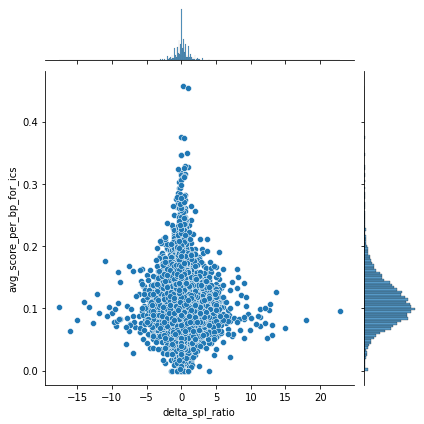

In [18]:
sns.jointplot(df, x='delta_spl_ratio',
              y='avg_score_per_bp_for_ics')